# Tensorflow KMeans by Shawn Simister

Source: https://gist.github.com/narphorium/d06b7ed234287e319f18

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import tensorflow as tf

Start off by defining some hyperparameters.

In [3]:
num_vectors = 1000
num_clusters = 3
num_steps = 100

Generate some sample data as a list of random 2D vectors from two overlapping normal distributions.

In [4]:
vector_values = []
for i in xrange(num_vectors):
  if np.random.random() > 0.5:
    vector_values.append([np.random.normal(0.5, 0.6),
                          np.random.normal(0.3, 0.9)])
  else:
    vector_values.append([np.random.normal(2.5, 0.4),
                         np.random.normal(0.8, 0.5)])

Create a scatter plot of the initial randomly distributed vectors.

/Users/luckow/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


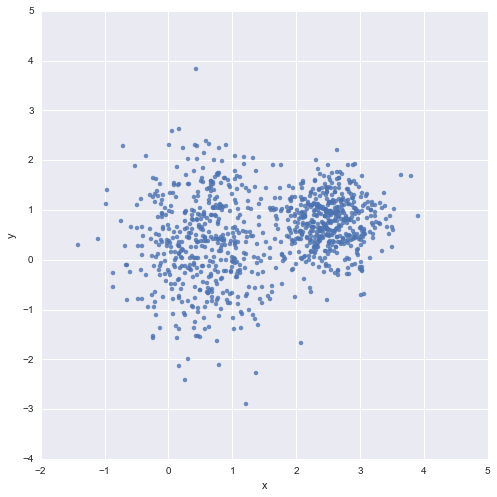

In [5]:
df = pd.DataFrame({"x": [v[0] for v in vector_values], 
                   "y": [v[1] for v in vector_values]})
sns.lmplot("x", "y", data=df, fit_reg=False, size=7)
plt.show()


Let's start building our k-means TensorFlow graph with a few simple operators:
- Store our vector input values in a 2D tensor constant. 
- Randomly shuffle the input vectors and then slice off the first `num_cluster` vectors as a 2D tensor and store the result in a Variable.

In [6]:
vectors = tf.constant(vector_values)
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), 
                                 [0,0],
                                 [num_clusters,-1])
                                 )

In [17]:
centroids.get_shape()

TensorShape([Dimension(3), Dimension(2)])

Here's where things get a little more complicated. We extend both of our 2D tensors into 3 dimensions so that we can do an element-wise subtraction between them. This would be pretty straight-forward except that these two tensors have completely different sizes.

In [7]:
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

print expanded_vectors.get_shape()
print expanded_centroids.get_shape()

TensorShape([Dimension(1), Dimension(1000), Dimension(2)])
TensorShape([Dimension(3), Dimension(1), Dimension(2)])


However, because of the *shape broadcasting* feature in Tensorflow, the `tf.sub` operators is still able to figure out how to do the element-wise subtraction between the two tensors. That allows us to calculate the squared Euclidian distances (no need to take the square-root) and determine the cluster assignments for every vector and centroid all at once.

In [8]:
distances = tf.reduce_sum(
  tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)

Once we have the cluster assignments, we can go back through the input vectors and gather all of the members of each cluster and average them together to calculate the new centroids for that cluster.

In [9]:
means = tf.concat(0, [
  tf.reduce_mean(
      tf.gather(vectors, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1])
  for c in xrange(num_clusters)])

Finally, we create an operator which assigns the means, which we just calculated, to the `centroids` variable so that the next time we run the graph it is using the updated centroids.

We also create a operator to initialize all of our variable before we run the graph.

In [10]:
update_centroids = tf.assign(centroids, means)
init_op = tf.initialize_all_variables()

Here's where we run our graph. For each step in `num_steps`, we update the centroids and fetch the values of those centroids as well as the cluster assignments for each of our input vectors. TensorFlow will figure out all of the dependencies so that all of the necessary operators in our graph will be evaluated in order to calculate the new centroids.

After all the steps have completed, we display the coordinates of our final centroids.

In [14]:
with tf.Session() as sess:
    sess.run(init_op)
    for step in xrange(num_steps):
        _, centroid_values, assignment_values = sess.run([update_centroids,
                                                          centroids,
                                                          assignments])
    print "centroids"
    print centroid_values

centroids
[[ 2.51112318  0.76467818]
 [ 0.48647496  1.01122272]
 [ 0.57322288 -0.51785576]]


We can now create a multi-colored scatter plot showing how our vectors have been clustered.

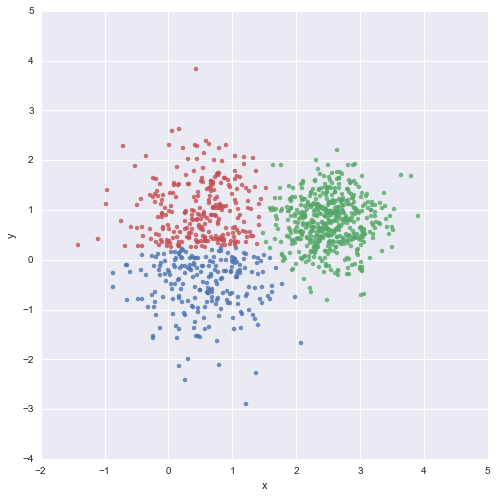

In [15]:
data = {"x": [], "y": [], "cluster": []}
for i in xrange(len(assignment_values)):
  data["x"].append(vector_values[i][0])
  data["y"].append(vector_values[i][1])
  data["cluster"].append(assignment_values[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, 
           fit_reg=False, size=7, 
           hue="cluster", legend=False)
plt.show()